# Data exploration and cleaning, creating features as we go

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

# nltk for natural language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# sklearn 
# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# similarity metric
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans

from data_visualization import plot_categorical_log

In [2]:
# I acquired this dataset myself from the IMDB website using a selenium webscraper
# df = pd.read_csv("IMDB_Sept.csv")
df = pd.read_csv("IMDB_Sept.csv")
# drop the weird column
df = df.drop(columns='Unnamed: 0', axis=1)

df = df.loc[df['Votes'] >= 100000] # keep movies with more than 100000 votes in IMDB, keeps popular movies 
df.shape

(1725, 14)

In [4]:
df.head(1)

,Actors,Budget($),Director,Genres,IMDB_Score,Metascore,Production_Company,Rated,Release_Date,Runtime,Storyline,Summary,Title,Votes
3104,"['Parminder Nagra', 'Keira Knightley', 'Jonath...",-1,Gurinder Chadha,"['Comedy', 'Drama', 'Romance', 'Sport']",6.6,66,['Charles Chaplin Productions'],12,12 April 2002 (UK),112,A comedy about bending the rules to reach your...,The daughter of orthodox Sikh rebels against h...,Bend It Like Beckham (2002),100011


# Check for NA values

In [5]:
print("Number of rows with NA: {n}".format(n=len(df[df.isna().any(axis=1)])))
print("Columns with NA: {n}".format(n=df.columns[df.isna().any()].tolist()))

Number of rows with NA: 17
Columns with NA: ['Release_Date', 'Title']


- The NA values are present because of the scraping process, our scraper couldn't find a title or release date for these movies. 
- Because there are so few of them, we will just drop the rows that contain NA values

In [6]:
df = df.dropna() # drop rows withNA values from df
titles = df.Title.tolist() # store titles of movies as a list for later on
df.shape

(1708, 14)

# Genre

In [7]:
print(df.Genres.iloc[0])
print(type(df.Genres.iloc[0]))

['Comedy', 'Drama', 'Romance', 'Sport']
<class 'str'>


- The genre column looks like a list but it is a string
- We want a list so we will have to clean it up
- We will create new column, count of genres in each movie
- Display the most popular genres

Example of cleaned genres: ['Comedy', 'Drama', 'Romance', 'Sport']

Number of different genres: 21

Top 1 genre: Drama: count: 801
Top 2 genre: Action: count: 609
Top 3 genre: Thriller: count: 587
Top 4 genre: Comedy: count: 523
Top 5 genre: Adventure: count: 502


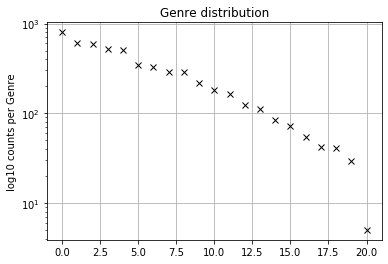

In [10]:
# apply the regex to all rows in our dataset
df['Genres_clean'] = [re.findall(r'[A-Z][A-z- ]+', genre_string) for genre_string in df.Genres] # Use a regex findall to convert our string to a list
# df['Number_of_genres'] = df['Genres_clean'].apply(lambda genre_list: len(genre_list)) # Create column with number of genres in each movie

print("Example of cleaned genres: {n}\n".format(n=df['Genres_clean'].iloc[0]))

genres_expanded = pd.Series([genre for row in df.Genres_clean for genre in row]) # expand our genres column, turning a list of lists into one long pandas series
print("Number of different genres: {n}\n".format(n=len(genres_expanded.unique())))

counts_per_genre = genres_expanded.value_counts(sort=True) # get value counts of our expanded genres series

# print top 5 genres
for i in range(5):
    print("Top {i} genre: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_genre.index.tolist()[i], 
                                                       num=counts_per_genre.tolist()[i]))

# call function from data_visualization.py
plot_categorical_log(counts_per_genre, "Genre")

## The IMDB website describes genres as either subjective or objective. 
###### https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG?ref_=helpart_nav_31#

I will encode the Objective genres with binary values. They include; Animation, Biography, Documentary, Family, Film-Noir, History, Musical, News, Reality-TV, Short, Sport, Talk-Show, War, Western. 
- A movie listed as 'Biography' will receive a value of 1 in the Biography column
- A movie listed as 'Biography'and 'War' will receive a value of 1 in the Biography and War columns

I will encode the Subjective genres with a weighted value depending on how many subjective genres are listed with the movie. They include; Drama, Comedy, Thriller, Action, Romance, Crime, Sci-Fi, Fantasy, Mystery, Horror, Music
- A movie listed as only 'Drama' will receive a value of 1.0 in the Drama column.
- A movie listed as 'Drama' and 'Romance' will receive a value of 0.5 in the respective column.
- A movie listed as 'Biography', 'Drama' and 'Romance' will receive a value of 1 for Biography(Objective) and a value of 0.5 in 'Drama' and 'Romance'

In [11]:
# Split the genres column into subjective and objective columns

# initialise our objective and subjetive genre lists
obj = ['Animation', 'Biography', 'Documentary', 'Family', 'Film-Noir', 'History', 'Musical',
       'News', 'Reality-TV', 'Short', 'Sport', 'Talk-Show', 'War', 'Western']

subj = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime',
        'Sci-Fi', 'Fantasy', 'Mystery', 'Horror', 'Music']

# methods to split the genres column into subjective and objective columns respectively
# I had issue with creating two columns in the df with one method so I had to seperate them
def split_genres_obj(genres):
    obj_g = []
    
    for g in genres:
        if g in obj:
            obj_g.append(g)
    return obj_g

def split_genres_subj(genres):
    subj_g = []
    
    for g in genres:
        if g in subj:
            subj_g.append(g)
    return subj_g


df['objective_genres'] = df.Genres_clean.apply(lambda genres: split_genres_obj(genres)) # create objective column
df['subjective_genres'] = df.Genres_clean.apply(lambda genres: split_genres_subj(genres)) # create subjective column

df['number_subjective_genres'] = df.subjective_genres.apply(lambda subjg: len(subjg)) # create column with number of subjective genres for later use

df[['Genres_clean', 'objective_genres', 'subjective_genres']].head(1)

,Genres_clean,objective_genres,subjective_genres
3104,"[Comedy, Drama, Romance, Sport]",[Sport],"[Comedy, Drama, Romance]"


## Encode our genres

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Enocde the objective genres with values of 1 and 0
obj_genre_df = pd.DataFrame(mlb.fit_transform(df.objective_genres),
                          columns=mlb.classes_,
                          index=df.index)

# Enocde the subjective genres with weighted values
subj_genre_df = pd.DataFrame(mlb.fit_transform(df.subjective_genres),
                          columns=mlb.classes_,
                          index=df.index)

subj_genre_df['count'] = df['number_subjective_genres']
subj_genre_df = subj_genre_df.loc[:,"Action":"Thriller"].div(subj_genre_df["count"], axis=0)
# subj_genre_df = subj_genre_df.div(subj_genre_df["count"], axis=0)

genre_df = pd.concat([obj_genre_df,subj_genre_df], axis=1)
genre_df['Title'] = df['Title']
genre_df = genre_df.fillna(0) # some movies get na values when we divided by a count of 0 for subjective genres
genre_df.head(1)

,Animation,Biography,Family,Film-Noir,History,Musical,Sport,War,Western,Action,...,Crime,Drama,Fantasy,Horror,Music,Mystery,Romance,Sci-Fi,Thriller,Title
3104,0,0,0,0,0,0,1,0,0,0.0,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,Bend It Like Beckham (2002)


In [13]:
print("NA values: {n}".format(n=len(genre_df[genre_df.isnull().any(axis=1)])))

NA values: 0


In [14]:
# save df for future use
genre_df.to_pickle('Pickles/genre_df.pkl')

# Production_Company

In [18]:
print(df['Production_Company'].iloc[0])
print(type(df['Production_Company'].iloc[0]))

['Charles Chaplin Productions']
<class 'str'>


- The Production_Company column contains a string but we want a list

Example of cleaned production company: ['Charles Chaplin Productions']
Number of production companies: 941

Top 1 production company: Universal Pictures: count: 189
Top 2 production company: Columbia Pictures: count: 153
Top 3 production company: Paramount Pictures: count: 148
Top 4 production company: Twentieth Century Fox: count: 139
Top 5 production company: Walt Disney Pictures: count: 118


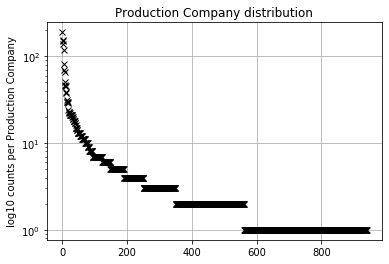

In [45]:
# apply the regex to all rows in our dataset
df['Prod_Comp_clean'] = [re.findall(r'[A-Z][A-z- ]+', pc) for pc in df.Production_Company]
df['Prod_Comp_clean'].head(1)

# apply the regex to all rows in our dataset
df['Prod_Comp_clean'] = [re.findall(r'[A-Z][A-z- ]+', pc_string) for pc_string in df.Production_Company]

print("Example of cleaned production company: {n}".format(n=df['Prod_Comp_clean'].iloc[0]))

pc_expanded = pd.Series([pc for row in df.Prod_Comp_clean for pc in row])
print("Number of production companies: {n}\n".format(n=len(pc_expanded.unique())))

counts_per_pc = pc_expanded.value_counts(sort=True)

for i in range(5):
    print("Top {i} production company: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_pc.index.tolist()[i], 
                                                       num=counts_per_pc.tolist()[i]))

# call function from data_visualization.py
plot_categorical_log(counts_per_pc, 'Production Company')

In [54]:
# use MultiLabelBinarizer to one hot encode values in a list 

mlb = MultiLabelBinarizer()
prodcom_df = pd.DataFrame(mlb.fit_transform(df.Prod_Comp_clean),
                          columns=mlb.classes_,
                          index=df.index)

# we will remove the production companies with only 1 movie, won't be useful for similarity metrics
first_single_count_pc = np.where(counts_per_pc==1)[0].min()

pc_to_keep = counts_per_pc[0:first_single_count_pc].index.tolist() # we are keeping the production companies with >1 movie

prodcom_df = prodcom_df[pc_to_keep] # filter out ones we don't want

# for every row in our dataframe, check if the sum of values in row equals 0, this indicates that there is no production company for this movie
num_prodcom = len([i for i in prodcom_df.sum(axis = 1, skipna = True).tolist() if i==0]) # i==0 returns movies without a production company in top 200
prodcom_df['Title'] = titles

print("Movie with no production company represented: {p}%".format(p=100*(round(num_prodcom/len(prodcom_df), 3))))
print(actor_df.shape)

Movie with no production company represented: 3.0%
(1708, 3711)


In [30]:
prodcom_df.to_pickle('Pickles/prodcom_df.pkl')

# Actor

In [32]:
# what the column currently looks like
print(df.Actors.iloc[0])
print(type(df.Actors.iloc[0]))

['Parminder Nagra', 'Keira Knightley', 'Jonathan Rhys Meyers', 'Anupam Kher', 'Archie Panjabi', 'Shaznay Lewis', 'Frank Harper', 'Juliet Stevenson', 'Shaheen Khan', 'Ameet Chana', 'Pooja Shah', 'Pavenpreet Kaur', 'Preeya Kalidas', 'Trey Farley', 'Saraj Chaudhry']
<class 'str'>


- The Actor column contains a string but we want a list

In [33]:
# apply the regex to all rows in our dataset
df['Actors_clean'] = [re.sub(r'[\"\[\]\']', '', actors_string).split(', ') for actors_string in df.Actors]
df['Actors_clean'].iloc[0]

['Parminder Nagra',
 'Keira Knightley',
 'Jonathan Rhys Meyers',
 'Anupam Kher',
 'Archie Panjabi',
 'Shaznay Lewis',
 'Frank Harper',
 'Juliet Stevenson',
 'Shaheen Khan',
 'Ameet Chana',
 'Pooja Shah',
 'Pavenpreet Kaur',
 'Preeya Kalidas',
 'Trey Farley',
 'Saraj Chaudhry']

- The Actors feature is now a series of lists, each list represents the actors in that movie. We can expand the list to see the most frequent actors

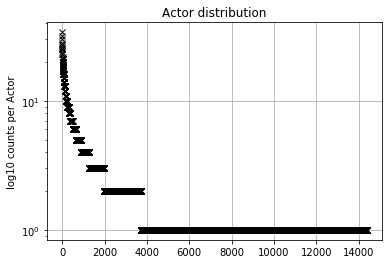

Number of actors: 14378

Top 1 actor: Samuel L. Jackson: count: 34
Top 2 actor: Robert De Niro: count: 32
Top 3 actor: Johnny Depp: count: 30
Top 4 actor: Morgan Freeman: count: 28
Top 5 actor: Bruce Willis: count: 27


In [46]:
actors_expanded = pd.Series([i for row in df.Actors_clean for i in row])
counts_per_actor = actors_expanded.value_counts(sort=True)

# call function from data_visualization.py
plot_categorical_log(counts_per_actor, 'Actor')

print("Number of actors: {num}\n".format(num=len(actors_expanded.unique())))

for i in range(5):
    print("Top {i} actor: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_actor.index.tolist()[i], 
                                                       num=counts_per_actor.tolist()[i]))

In [58]:
mlb = MultiLabelBinarizer()
actor_df = pd.DataFrame(mlb.fit_transform(df.Actors_clean),
                          columns=mlb.classes_,
                          index=df.index)

# like production companies, we will remove the actors with only 1 movie
first_single_count_actor = np.where(counts_per_actor==1)[0].min()

actor_to_keep = counts_per_actor[0:first_single_count_actor].index.tolist() # we are keeping the production companies with >1 movie

actor_df = actor_df[actor_to_keep] # filter out ones we don't want

num_actors = len([i for i in actor_df.sum(axis = 1, skipna = True).tolist() if i==0])
print("Movies with no actor represented: {p}%".format(p=100*(round(num_actors/len(actor_df), 2))))

actor_df['Title'] = titles
actor_df.shape

Movies with no actor represented: 1.0%


(1708, 3711)

In [ ]:
# plot the percentage of movies covered by top n actors
# num_actors_coverage = []
# for n in range(1000):
#     if n > 0:
#         actors_to_keep = counts_per_actor[0:n].index.tolist() # we are keeping the top n actors based on their movie counts
#         temp = actor_df[actors_to_keep] # filter out ones we don't want

#         num_actors = len([i for i in temp.sum(axis = 1, skipna = True).tolist() if i>0]) # i==0 returns movies without an actor in top 200
#         perc = 100*(round(num_actors/len(temp), 4))

#         actor_coverage_dict = {'Number_of_actors': n,
#                                'percentage_of_movies_not_covered': perc}

#         num_actors_coverage.append(actor_coverage_dict)

# actor_coverage_df = pd.DataFrame(num_actors_coverage)
# del(temp)

# plt.figure()
# plt.plot(actor_coverage_df.Number_of_actors, actor_coverage_df.percentage_of_movies_not_covered)
# plt.grid('on')
# plt.title('Most frequent actors - coverage of movies')
# plt.xlabel('Number of actors')
# plt.ylabel('Percentage of movies covered')
# plt.show()

In [49]:
actor_df.to_pickle('Pickles/actor_df.pkl')

# Director

Number of movies: 1708
Number of director: 708

Top 1 actor: Steven Spielberg: count: 23
Top 2 actor: Ridley Scott: count: 15
Top 3 actor: Tim Burton: count: 14
Top 4 actor: Michael Bay: count: 13
Top 5 actor: Robert Zemeckis: count: 13


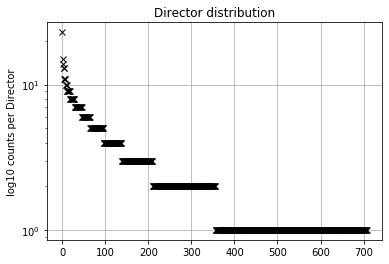

In [50]:
print("Number of movies: {num}".format(num=len(df)))
print("Number of director: {num}\n".format(num=len(df.Director.unique())))

counts_per_director = df.Director.value_counts(sort=True)

for i in range(5):
    print("Top {i} actor: {name}: count: {num}".format(i=i+1, 
                                                       name=counts_per_director.index.tolist()[i], 
                                                       num=counts_per_director.tolist()[i]))
    
# call function from data_visualization.py
plot_categorical_log(counts_per_director, 'Director')

In [56]:
# plot the percentage of movies covered by top n actors

director_df = pd.get_dummies(df.Director) # one hot encode the director column

# like before, we will remove the directors with only 1 movie
first_single_count_director = np.where(counts_per_director==1)[0].min()

director_to_keep = counts_per_director[0:first_single_count_director].index.tolist() # we are keeping the directors with >1 movie

director_df = director_df[director_to_keep] # filter out ones we don't want

# sum over the column axis. 
num_directors = len([i for i in director_df.sum(axis = 1, skipna = True).tolist() if i==0])
director_df['Title'] = titles

print("Movies with no director represented: {p}%".format(p=100*(round(num_directors/len(director_df), 2))))
print(director_df.shape)

Movies with no director represented: 21.0%
(1708, 357)


- the high number of samples with no director is likely caused by our filtering out movies with less than 100000 votes on imdb. The movies with less votes are less popular and may have been directed by obscure directors

In [59]:
director_df.to_pickle('Pickles/director_df.pkl')

# Storyline

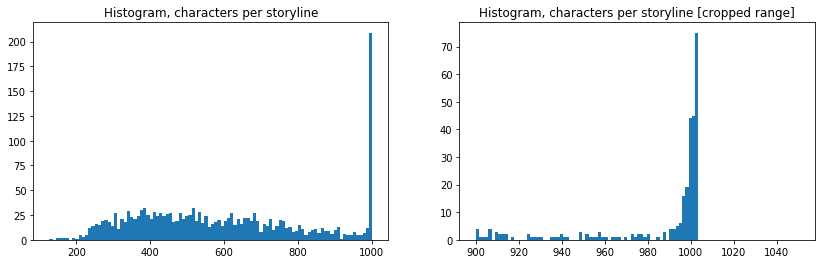

In [60]:
chars_per_storyline = [len(i) for i in df.Storyline]

df['storyline_chars'] = chars_per_storyline

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14, 4), sharey=False, sharex=False)  # 1 row, 2 columns
ax1.hist(x=chars_per_storyline, bins=100)
ax1.set_title('Histogram, characters per storyline')

ax2.hist(x=chars_per_storyline, bins=100, range=(900,1050))
ax2.set_title('Histogram, characters per storyline [cropped range]')

plt.show()

- The abrupt stop in the counts of characters in the storyline is likely due to max characters for the storyline on IMDB

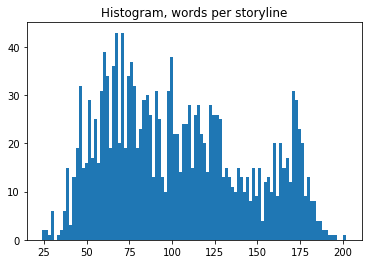

In [62]:
words_per_storyline = [len(i.split()) for i in df.Storyline]
df['storyline_words'] = words_per_storyline

plt.hist(x=words_per_storyline, bins=100)
plt.title('Histogram, words per storyline')
    
plt.show()

In [63]:
mean_words = int(df.storyline_words.mean())
print("Mean number of words in Storyline: {n}".format(n=mean_words))
mean_chars = int(df.storyline_chars.mean())
print("Mean number of chars in Storyline: {n}".format(n=mean_chars))

Mean number of words in Storyline: 103
Mean number of chars in Storyline: 598


- Nothing unusual in the distribution of the words in Storyline
- The difference between the character and word count is interesting. The characters abruptly stop. May be due to there being lots of combinations of varaying length words to reach max characters

## We will use the Storyline to engineer text features

In [65]:
# nltk.download('punkt')
# nltk.download('stopwords')

# Remove punctuation
df['Storyline_no_punct'] = df['Storyline'].apply(lambda row: re.sub(r'[\',.\"]', '', row))

# tokenize
df['storyline_tokens'] = df['Storyline_no_punct'].apply(lambda row: word_tokenize(row))

# lower all the tokens
df['storyline_tokens'] = df['storyline_tokens'].apply(lambda row: [i.lower() for i in row])

# view results
df[['Storyline', 'storyline_tokens']].iloc[0]

# remove stopwords
stop_words = stopwords.words("english")
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['storyline_tokens'] = df['storyline_tokens'].apply(lambda row: remove_stopwords(row))

df[['Storyline', 'storyline_tokens']].head(1)

,Storyline,storyline_tokens
3104,A comedy about bending the rules to reach your...,"[comedy, bending, rules, reach, goal, bend, li..."


## Stemming

In [66]:
ss_en = SnowballStemmer('english')

def stem_words(tokens):
    return [ss_en.stem(i) for i in tokens]

df['storyline_tokens_stem'] = df['storyline_tokens'].apply(
                                        lambda row: stem_words(row))
    
df[['Storyline', 'storyline_tokens_stem']].head(1)

,Storyline,storyline_tokens_stem
3104,A comedy about bending the rules to reach your...,"[comedi, bend, rule, reach, goal, bend, like, ..."


In [67]:
def token_to_sentence(tokens):
    return ' '.join(word for word in tokens)

df['storyline_stem'] = df['storyline_tokens_stem'].apply(lambda row: token_to_sentence(row))

In [68]:
print("Rows with NA: {n}:".format(n=len(df[df.isnull().any(axis=1)])))

Rows with NA: 0:


## Vectorization

In [73]:
text_data = df['storyline_stem']
text_data_array = np.array(text_data)

# And now testing TFIDF vectorizer:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data_array)

In [74]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()
print("Number of features %s" % len(feature_names))

Number of features 6580


In [91]:
# create df from our tfidf matrix
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = feature_names)
tfidf_df['Title'] = titles

In [92]:
tfidf_df.to_pickle('Pickles/tfidf_df.pkl')